In [1]:
from PIL import Image, ImageOps
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
import torch.backends.cudnn as cudnn
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from enum import Enum
import os
from typing import List, Tuple
import rasterio
import rasterio.plot
import math
import time
import gc
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import seaborn as sbn

cudnn.benchmark = True
sbn.set_theme()

In [2]:
ml_weights_dir = os.path.join('ML', 'weights')

In [3]:
gc.collect()
torch.cuda.empty_cache()

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [5]:
class_names =   ['CLR', 'FEW', 'SCT', 'BKN', 'OVC']
classes = list(range(len(class_names)))
class_dict = {name: i for i, name in enumerate(class_names)}

In [6]:
weights = EfficientNet_V2_S_Weights.DEFAULT

In [7]:
seq_model = efficientnet_v2_s(weights=weights)

freez_model_base = False
if freez_model_base:
    for param in seq_model.parameters(): #freeze model
        param.requires_grad = False

seq_model.classifier[1] = nn.Linear(1280, len(classes))
print(seq_model.classifier)
model = nn.DataParallel(seq_model)
model = model.to(device)

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=5, bias=True)
)


In [8]:
batch_size = 16

In [9]:
show_summary = False

if show_summary:
    summary(
        model,
        input_size=(batch_size, 3, 300, 300),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
    )

In [10]:
data_dir = 'data'
dataset_dir = os.path.join(data_dir, 'dataset')

In [11]:
training_weights = pd.read_csv(os.path.join(dataset_dir, 'training_weights.csv'), index_col='label')
training_weights

,weight
label,
CLR,1.874134
FEW,11.590317
SCT,10.957746
BKN,8.410811
OVC,5.882798


In [64]:
class DatasetType(str, Enum):
    TRAINING = 'training'
    VALIDATION = 'validation'
    TEST = 'test'

class AimlsseImageDataset(Dataset):
    def __init__(self, type:DatasetType, dataset_dir:str, bands:List[str], station_radius:float,
                 transfrom=None, target_transform=None) -> None:
        super().__init__()
        self.bands_metadata = pd.read_csv(os.path.join(dataset_dir, f'bands_metadata.csv'))
        self.bands_metadata.set_index('band', inplace=True)
        bands_series = pd.Series(bands)
        invalid_bands = bands_series[~bands_series.isin(self.bands_metadata.index)].to_list()
        if any(invalid_bands):
            raise ValueError(f'Bands {invalid_bands} are not valid')
        if len(self.bands_metadata.loc[bands]['resolution [m]'].unique()) != 1:
            raise ValueError(f'Bands {bands} do not have the same resolution')
        self.bands = bands
        self.station_radius = station_radius
        self.img_labels = pd.read_csv(os.path.join(dataset_dir, f'{type.value}_labels.csv'))
        self.img_dir = os.path.join(dataset_dir, type.value)
        self.transform = transfrom
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, index) -> Tuple[np.ndarray, int]:
        image = self.get_image(index)
        label = self.get_label(index)
        return image, label
    
    def get_image(self, index) -> np.ndarray:
        path = os.path.join(self.img_dir, self.img_labels.iloc[index]['station'],
                                  f'{self.img_labels.iloc[index].product_id}.tif')
        image = rasterio.open(path)
        image_tensor = torch.from_numpy(image.read())
        image.close()
        # Select label and perform transformations
        if self.transform:
            image_tensor = self.transform(image_tensor)
        return image_tensor

    def get_label(self, index) -> int:
        label = class_dict[self.img_labels.iloc[index]['max cloud cover']]
        if self.target_transform:
            label = self.target_transform(label)
        return label


In [65]:
composed_transforms = transforms.Compose([
    
])

In [66]:
bands = ['B4', 'B3', 'B2']
station_radius = 8000.0
train_dataset = AimlsseImageDataset(DatasetType.TRAINING,           dataset_dir, bands, station_radius, transfrom=composed_transforms)
validation_dataset = AimlsseImageDataset(DatasetType.VALIDATION,    dataset_dir, bands, station_radius, transfrom=composed_transforms)
test_dataset = AimlsseImageDataset(DatasetType.TEST,                dataset_dir, bands, station_radius, transfrom=composed_transforms)

In [67]:
use_weighted_sampler = False
if use_weighted_sampler:
    num_samples = len(train_dataset)
    weights = [0] * num_samples
    for i in range(num_samples):
        label = train_dataset.get_label(i)
        weights[i] = training_weights.loc[class_names]['weight'].iloc[label]
    training_sampler = WeightedRandomSampler(weights, num_samples)

In [68]:
if use_weighted_sampler:
    train_dataloader =  DataLoader(train_dataset,       batch_size=batch_size, sampler=training_sampler)
else:
    train_dataloader =  DataLoader(train_dataset,       batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset,  batch_size=batch_size, shuffle=True)
test_dataloader =       DataLoader(test_dataset,        batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([16, 3, 300, 300]) ['CLR', 'FEW', 'SCT', 'BKN', 'OVC']
['FEW', 'CLR', 'OVC', 'SCT', 'CLR', 'CLR', 'BKN', 'OVC']
['CLR', 'CLR', 'OVC', 'CLR', 'FEW', 'CLR', 'OVC', 'FEW']


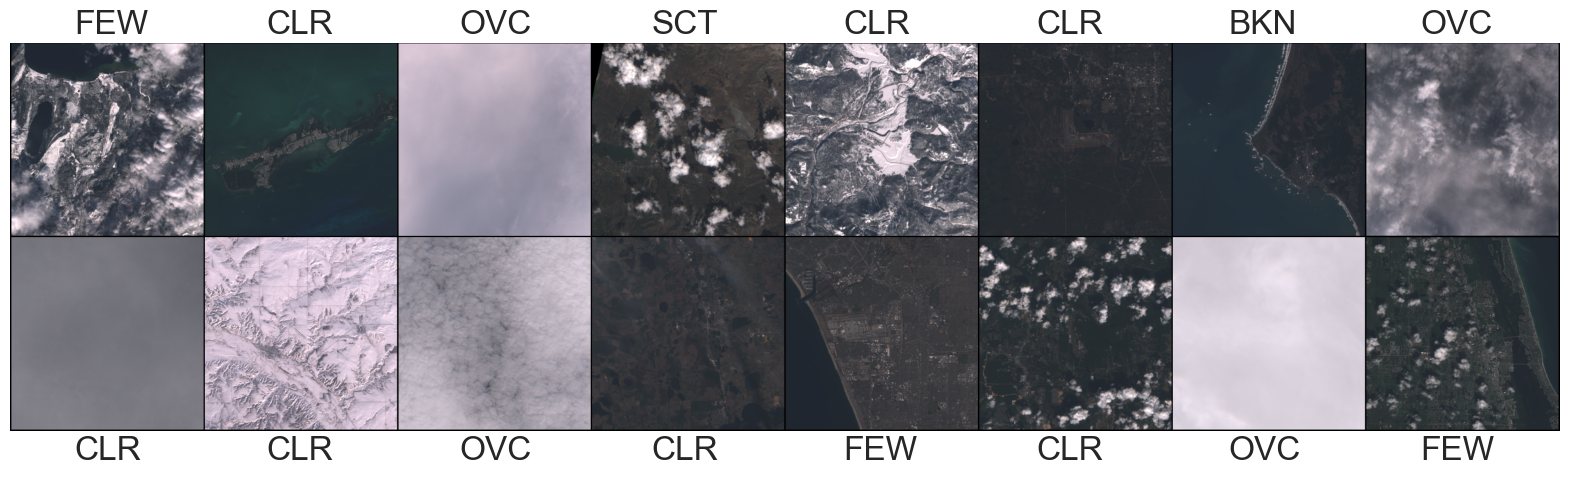

In [113]:
show_samples = True

def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def imshow(input_tensor: torch.Tensor, figsize:Tuple[float, float], title=None) -> Tuple[plt.Figure, plt.Axes]:
    """Imshow for Tensor."""
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('off')
    ax.imshow(input_tensor.permute(1, 2, 0))
    return fig, ax

if show_samples:
    # Get a batch of training data
    inputs, classes = next(iter(train_dataloader))
    print(inputs.shape, [class_names[c] for c in classes.unique().numpy()])

    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs)
    out.shape
    
    fig, ax = imshow(out, (20, 20))
    for i, row in enumerate(list(chunks([class_names[c] for c in classes.numpy()], 8))):
        for j, label in enumerate(row):
            ax.text(100 + j * 300, -15 + i * 665, label, fontsize=24)
        print(row)

In [23]:
from typing import List, Dict

class MLState:
    best_model_weights: Dict = {}
    model_state: Dict = {}
    optimizer_state: Dict = {}
    epoch: int = 0
    best_f1: float = 0.0
    scoreboard: List = []
    
    def __init__(self, best_model_weights: Dict = {}, model_state: Dict = {}, optimizer_state: Dict = {}, epoch: int = 0, best_f1: float = 0.0, scoreboard: List = []):
        self.best_model_weights = best_model_weights
        self.model_state = model_state
        self.optimizer_state = optimizer_state
        self.epoch = epoch
        self.best_f1 = best_f1
        self.scoreboard = scoreboard

def save_state(path:str, state:MLState):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save({
        'epoch': state.epoch,
        'best_model_weights': state.best_model_weights,
        'model_state_dict': state.model_state,
        'optimizer_state_dict': state.optimizer_state,
        'best_f1': state.best_f1,
        'scoreboard': state.scoreboard
    }, path)
    
def load_state(path:str) -> MLState:
    if os.path.exists(path):
        checkpoint = torch.load(path)
        return MLState(
            checkpoint['best_model_weights'],
            checkpoint['model_state_dict'],
            checkpoint['optimizer_state_dict'],
            checkpoint['epoch'],
            checkpoint['best_f1'],
            checkpoint['scoreboard']
        )
    else:
        raise ValueError(f'{path} is not a valid path to a stored machine learning state')

In [24]:
import copy


def train_model(model, criterion, optimizer, scheduler, num_epochs=25, load_checkpoint=True, checkpoint_filename='chkpt.pt'):
    since = time.time()

    checkpoint_path = os.path.join('ML', 'checkpoints', checkpoint_filename)
    os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
    if load_checkpoint and os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        best_model_weights = checkpoint['best_model_weights']
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_f1 = checkpoint['best_f1']
        scoreboard = checkpoint['scoreboard']
    else:
        best_model_weights = copy.deepcopy(model.state_dict())
        best_f1 = 0.0
        scoreboard = []
        start_epoch = 0

    if start_epoch >= num_epochs:
        print(f'Starting from epoch {start_epoch} but only wanted {num_epochs} epochs - returning current model instead')
        return model
    
    for epoch in range(start_epoch, num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataset = train_dataset
                dataloader = train_dataloader
                model.train()  # Set model to training mode
            else:
                dataset = validation_dataset
                dataloader = validation_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            y_true = []
            y_pred = []
            start_time = time.perf_counter()
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
            if phase == 'train':
                scheduler.step()
            end_time = time.perf_counter()
            phase_name = None
            if phase == 'train':
                phase_name = 'Training'
            elif phase == 'val':
                phase_name = 'Validation'
            delta_time = end_time - start_time
            print(f'{phase_name} took {delta_time:.1f} [s]')

            epoch_loss = running_loss / len(dataset)
            epoch_acc = running_corrects.double() / len(dataset)
            print(f'\tLoss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            epoch_precision, epoch_recall, epoch_f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
            print(f'\tPrecision: {epoch_precision} Recall: {epoch_recall} F1-Score: {epoch_f1_score}')
            
            scoreboard += [{
                'epoch': epoch,
                'phase': phase_name,
                'loss': epoch_loss,
                'accuracy': epoch_acc,
                'precision': epoch_precision,
                'recall': epoch_recall,
                'f1_score': epoch_f1_score,
                'time': delta_time
            }]
            
            # deep copy the model
            if phase == 'val' and epoch_f1_score > best_f1:
                best_f1 = epoch_f1_score
                best_model_weights = copy.deepcopy(model.state_dict())
        
        torch.save({
            'epoch': epoch,
            'best_model_weights': best_model_weights,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_f1': best_f1,
            'scoreboard': scoreboard
        }, checkpoint_path)
        
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best validation F1-Score: {best_f1:4f}')

    # load best model weights
    model.load_state_dict(best_model_weights)
    return model

In [25]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(validation_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            # _, preds = torch.max(outputs, 1)
            preds = outputs.data.max(1, keepdim=True)[1]

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [26]:
use_weighted_loss_function = True
if use_weighted_loss_function:
    loss_function_weights = torch.tensor(training_weights['weight'].to_list())
    loss_function_weights = loss_function_weights.to(device)
    print(loss_function_weights)

tensor([0.4671, 0.9150, 0.9083, 0.8819, 0.8278], device='cuda:0')


In [94]:
def display_confusion_matrix(model, dataloader, num_images=None):
    # set the model to evaluation mode
    model.eval()

    # initialize the true and predicted labels
    true_labels = []
    predicted_labels = []

    # get predictions for N images from the dataloader
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            if (num_images is not None) and (i == num_images):
                break
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            true_labels += labels.cpu().numpy().tolist()
            predicted_labels += predicted.cpu().numpy().tolist()

    # compute the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=range(len(classes)))

    # display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
    plt.grid(False)
    plt.title('Confusion matrix')
    plt.show()

In [28]:
if use_weighted_loss_function:
    criterion = nn.CrossEntropyLoss(loss_function_weights)
else:
    criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(seq_model.classifier.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [23]:
model_trained = train_model(model, criterion, optimizer, scheduler, num_epochs=25)

Epoch 24/24
----------


100%|██████████| 53/53 [20:32<00:00, 23.26s/it]


Training took 1232.9 [s]
	Loss: 0.6945 Acc: 0.7904
	Precision: 0.8001975973354656 Recall: 0.7903943077379187 F1-Score: 0.7937870157358844


100%|██████████| 7/7 [02:35<00:00, 22.17s/it]


Validation took 155.2 [s]
	Loss: 1.0743 Acc: 0.7335
	Precision: 0.729218012649229 Recall: 0.7334905660377359 F1-Score: 0.7283439342142748
Training complete in 23m 9s
Best validation F1-Score: 0.735804


In [87]:
state = load_state(os.path.join('ML', 'checkpoints', 'chkpt.pt'))

ValueError: ML\checkpoints\chkpt.pt is not a valid path to a stored machine learning state

In [26]:
save_state(os.path.join('ML', 'states', 'efficientnet_v2_s_300img_x64_weighted_loss_nofreeze_???.pt'), state)

In [88]:
model_trained = model
model_trained.load_state_dict(state.model_state)

<All keys matched successfully>

In [91]:
visualization_dataloader = DataLoader(validation_dataset,  batch_size=16, shuffle=True)

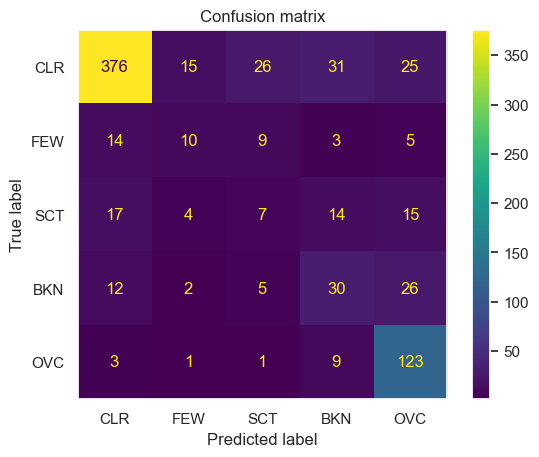

In [95]:
display_confusion_matrix(model_trained, visualization_dataloader)

In [29]:
state = load_state(os.path.join('ML', 'states', 'efficientnet_v2_s_300img_x64_weighted_loss_nofreeze.pt'))

In [39]:
pd.set_option('display.max_colwidth', None)

In [44]:
scoreboard = pd.DataFrame(state.scoreboard)
scoreboard['accuracy'] = scoreboard['accuracy'].apply(lambda t: t.item())
scoreboard.head()

,epoch,phase,loss,accuracy,precision,recall,f1_score,time
0,0,Training,1.117906,0.679810,0.690412,0.679810,0.683680,690.906046
1,0,Validation,1.150405,0.653302,0.703633,0.653302,0.669492,83.337102
2,1,Training,0.955457,0.731989,0.740960,0.731989,0.734358,697.732181
3,1,Validation,1.052330,0.662736,0.729217,0.662736,0.689851,82.945652
4,2,Training,0.944047,0.731100,0.747832,0.731100,0.736904,701.620562


In [45]:
scoreboard_training = scoreboard[scoreboard['phase'] == 'Training']
scoreboard_validation = scoreboard[scoreboard['phase'] == 'Validation']

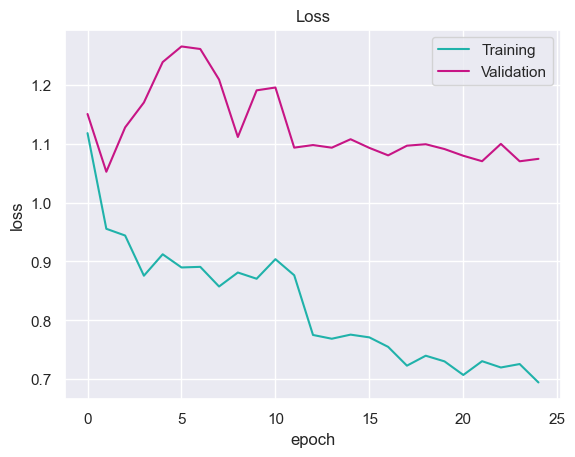

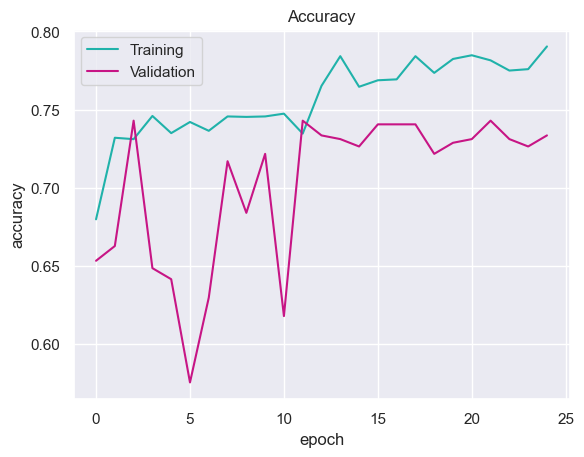

In [84]:
def plot_scoreboard(x_label:str, y_label:str):
    assert x_label in scoreboard, f'Label {x_label} is not in scoreboard'
    assert y_label in scoreboard, f'Label {y_label} is not in scoreboard'
    colors = {
        'Training': 'lightseagreen',
        'Validation': 'mediumvioletred'
    }
    fig, ax = plt.subplots()
    for phase in ['Training', 'Validation']:
        data = scoreboard[scoreboard['phase'] == phase]
        ax.plot(x_label, y_label, data=data, label=phase, color=colors[phase])
    ax.legend(loc='best')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(y_label.capitalize())

plot_scoreboard('epoch', 'loss')
plot_scoreboard('epoch', 'accuracy')

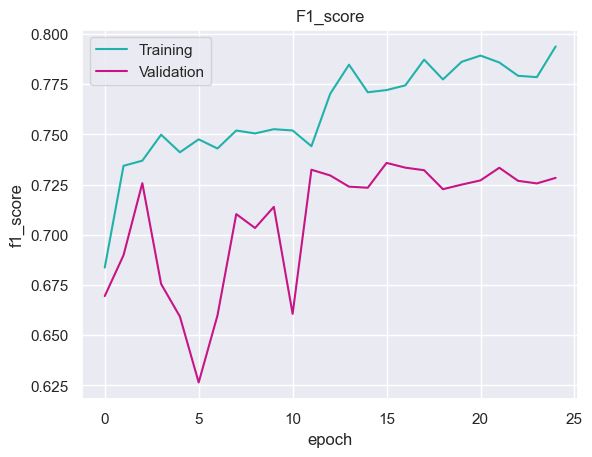

In [85]:
plot_scoreboard('epoch', 'f1_score')